In [1]:
import numpy as np
import pandas as pd
import acquire
import prepare
import model
import explore
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

# Acquisition

In this stage, we use a SQL query to access the Codeup MySQL database and join all the relevant data from each of the tables in the zillow database.

The data obtained includes all Single Family Residential properties which had a transaction in 2017. 

The `zillow_data` function from the `acquire` module performs this acquisition

In [2]:
# acquire data from the Codeup cloud database
df = acquire.zillow_data()

Reading from local CSV...


In [3]:
# the initial dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77579 entries, 0 to 77578
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77579 non-null  int64  
 1   parcelid                      77579 non-null  int64  
 2   airconditioningtypeid         25007 non-null  float64
 3   architecturalstyletypeid      207 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77579 non-null  float64
 6   bedroomcnt                    77579 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49809 non-null  float64
 9   calculatedbathnbr             76963 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6037 non-null   float64
 12  calculatedfinishedsquarefeet  77378 non-null  float64
 13  f

# Preparation

In this stage, we clean and prepare the data for further exploration and modeling and encapsulate the relevant code in the prepare modele.

The `prep_zillow` function from the `prepare` module accomplishes the following:

- filters the data for only Single Family Residential properties
- drops redundant foreign key identification code columns
- drops other redundant, irrelevant, or non-useful columns
- handles null valuesby:
    - filling null values with 0's in the following columns, since it is reasonable to assume nulls in these columns represent zero values: 
        - `fireplacecnt`, `garagecarcnt`, `garagetotalsqft`, `hashottuborspa`, `poolcnt`, `threequarterbathnbr`, `taxdelinquencyflag`
    - then dropping columns that remain where greater than 5% of values in that column are null
    - then dropping rows that remain with any null values
- changes data types to more appropriately reflect the data they represent
- adds the following engineered feature columns (see data-dictionary for details):
    - `age`, `bool_has_garage`, `bool_has_pool`, `bool_has_fireplace`, `taxvalue_per_sqft`, `taxvalue_per_bedroom`, `taxvalue_per_bathroom`
- adds the following target-related columns (for exploration) (see data-dictionary for details): 
    - `abs_logerror`, `logerror_direction`

In [4]:
# clean and prep the data using the steps outlined above
df = prepare.prep_zillow(df)
# the resulting dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51788 entries, 0 to 77578
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bathroomcnt                 51788 non-null  float64
 1   bedroomcnt                  51788 non-null  float64
 2   sqft                        51788 non-null  float64
 3   fips                        51788 non-null  object 
 4   fireplacecnt                51788 non-null  float64
 5   fullbathcnt                 51788 non-null  float64
 6   garagecarcnt                51788 non-null  float64
 7   garagetotalsqft             51788 non-null  float64
 8   bool_hashottuborspa         51788 non-null  object 
 9   latitude                    51788 non-null  float64
 10  longitude                   51788 non-null  float64
 11  lotsizesquarefeet           51788 non-null  float64
 12  poolcnt                     51788 non-null  float64
 13  propertycountylandusecode   517

Next we split the data into train, validate, and test samples for modeling.

The `train_validate_test_split` function from the `prepare` module performs this splitting action.

In [5]:
# split the data into three samples and print the sample sizes
train, validate, test = prepare.train_validate_test_split(df)
# identify the target label
target = 'logerror'

train	 n = 29001
test	 n = 10358
validate n = 12429


Initial exploration of the data revealed significant outliers in nearly all categories. 

We judge that our model will generalize more effectively if it is focused on the typical (i.e. median) homes. Further, we expect that markets for luxury and historical homes (likely represented by these outliers) are considerably different than the general home market, and that an altogether separate model would be more useful for predicting the values of such homes.

We will therefore drop outliers from this dataset.

The `remove_outliers` function from the `prepare` module calculates a range defining outliers based on the training sample, then removes values outside this range in all samples.

In [6]:
# identify columns for which to remove outliers
outlier_columns = [col for col in df.columns if ((df[col].dtype != 'object') & (col not in [target, 'latitude', 'longitude']))]
# calculate outliers and remove from all samples
train, validate, test = prepare.remove_outliers(train, validate, test, 3, outlier_columns)

train	 n = 15874
test	 n = 5731
validate n = 6750


Unfortunately, removing outliers like this based on all columns removed nearly half the data. In future iterations of this analysis, we will attempt to find ways to keep more of this data, such as identifying columns where removing outliers might not be appropriate, or using a larger outlier range for some columns rather than others.

Next, we scale quantitative features so that they can be appropriately compared to each other within our models.

The `scale_zillow` function from the `prepare` module uses a min-max scaler to convert all values to a range between 0 and 1.

In [7]:
# scale the data using sklearn MinMaxScaler()
train, validate, test = prepare.scale_zillow(train, validate, test, target)

Next, we add some additional engineered features to our dataset, created based on the clusters we found during the exploration phase. The process of creating these clusters will be shown in more detail below. 

The `add_clusters` function from the `prepare` module as these features to the dataframe.

In [8]:
# create clusters and add as features to the datasets
train, validate, test = prepare.add_clusters(train, validate, test)

Finally, the `encode_zillow` function from the `prepare` module uses a one-hot encoder to represent all categorical features as either 0 or 1, so they too can be appropriately compared within the model.

In [9]:
# encode the data using pandas get_dummies
train, validate, test = prepare.encode_zillow(train, validate, test, target)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15874 entries, 23280 to 19266
Data columns (total 80 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   bathroomcnt                           15874 non-null  float64
 1   bedroomcnt                            15874 non-null  float64
 2   sqft                                  15874 non-null  float64
 3   fips                                  15874 non-null  object 
 4   fireplacecnt                          15874 non-null  float64
 5   fullbathcnt                           15874 non-null  float64
 6   garagecarcnt                          15874 non-null  float64
 7   garagetotalsqft                       15874 non-null  float64
 8   bool_hashottuborspa                   15874 non-null  object 
 9   latitude                              15874 non-null  float64
 10  longitude                             15874 non-null  float64
 11  lotsizesqua

# Exploration

### Explore - Correlations

#### Which features have the highest correlations with logerror?

The `target_correlations` function from the `explore` module displays a heatmap of the absolute values of correlations between each quantitive feature and our target variable

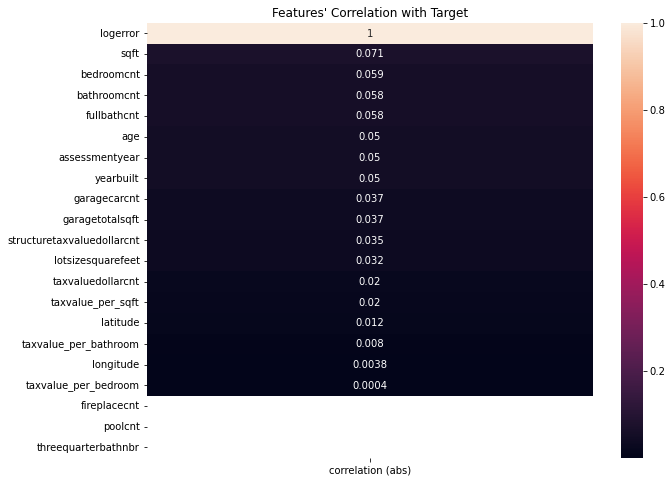

In [11]:
# identify quantitative feature columns
quant_cols = [col for col in train.columns if (train[col].dtype != 'object') & ('enc_' not in col) & ('scaled_' not in col) & ('bool_' not in col) & (col != 'abs_logerror')]
# create a seaborn heatmap of the absolute value of correlations between quantitive features and the target
explore.target_correlations(train[quant_cols], target)

From this we can see that no one feature by itself has a very strong correlation with logerror. 

However, we will use this to guide which features will go into our initial model, by taking all features whose correlation value is .05 or higher...
- sqft
- bedroomcnt
- bathroomcnt
- fullbathcnt
- age
- assessmentyear
- yearbuilt
    
...then adding our cluster features to see if they have an impact on the model performance.

### Explore - Clustering

#### Are there clusters based on number of bedrooms and number of bathrooms that are drivers of logerror?

We created 3 clusters using a k-means algorithm based on the `bedroomcnt` and `bathroomcnt` features, the results of which are visualized below using the `viz_cluster_BedBath` function from the `explore` module:

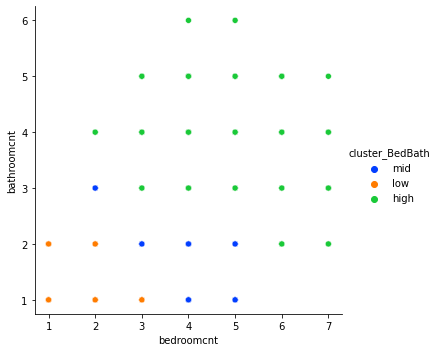

In [12]:
# use seaborn to display bedroomcnt, bathroomcnt, by cluster_BedBath
explore.viz_cluster_BedBath(train)

Next we examine the difference in logerror among the three clusters, using the `viz_logerror_BedBath` function from the `explore` module:

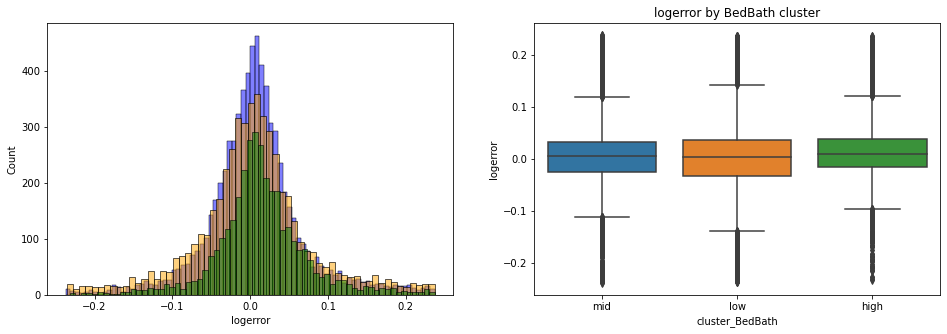

In [13]:
# use seaborn to create histograms and boxplots of logerror by cluster_BedBath
explore.viz_logerror_BedBath(train)

Finally, we test the likelihood that differences in logerror might be observed only due to chance:

The `test_cluster_BedBath` function conducts this statistical test and displays the results.

In [14]:
# use SciPy to conduct an ANOVA test on the logerror values for each cluster
explore.test_cluster_BedBath(train)


H0:  There is no significant difference in logerror among the BedBath clusters.
H1:  There is a significant difference in logerror among the BedBath clusters.

alpha =  0.05

stat =  25.339809268693223
p =  1.029423199371789e-11

Reject H0


Since p is less than alpha, we reject the null hypothesis, and we proceed under the assumption that there is a significant difference in logerror among the BedBath clusters. Therefore, we expect these clusters to be drivers of logerror.

#### Are there clusters based on combination of number of bedrooms, number of bathrooms, and square footage that are drivers of logerror?

We created 3 clusters using a k-means algorithm based on the `sqft`, `bedroomcnt` and `bathroomcnt` features, the results of which are visualized below using the `viz_cluster_BedBathSqft` function from the `explore` module:

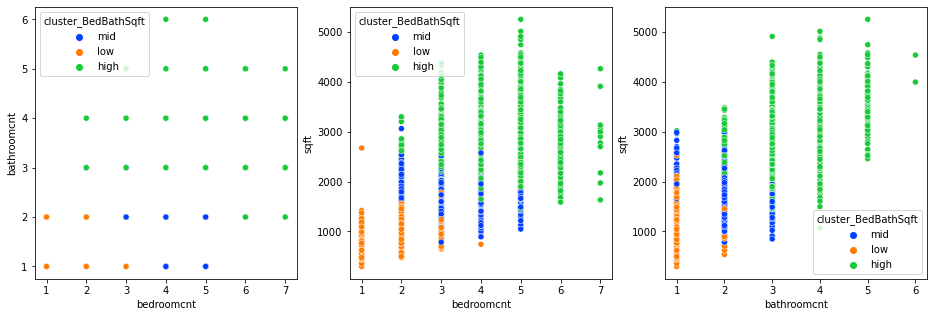

In [15]:
explore.viz_cluster_BedBathSqft(train)

Next we examine the difference in logerror among the three clusters, using the `viz_logerror_BedBathSqft` function from the `explore` module:

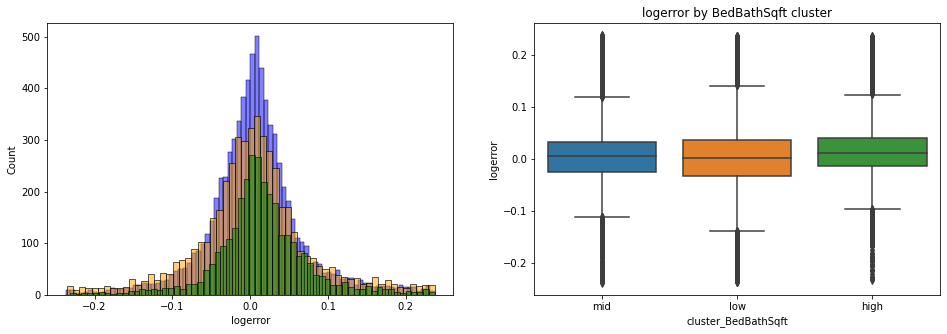

In [16]:
explore.viz_logerror_BedBathSqft(train)

Finally, we test the likelihood that differences in logerror might be observed only due to chance:

The `test_cluster_BedBathSqft` function conducts this statistical test and displays the results.

In [17]:
explore.test_cluster_BedBathSqft(train)


H0:  There is no significant difference in logerror among the BedBathSqft clusters.
H1:  There is a significant difference in logerror among the BedBathSqft clusters.

alpha =  0.05

stat =  28.96448373796259
p =  2.778341627048375e-13

Reject H0


Since p is less than alpha, we reject the null hypothesis, and we proceed under the assumption that there is a significant difference in logerror among the BedBathSqft clusters. Therefore, we expect these clusters to be drivers of logerror.

#### Are there clusters based on number of bedrooms, number of bathrooms, and tax value per square foot that are drivers of logerror?

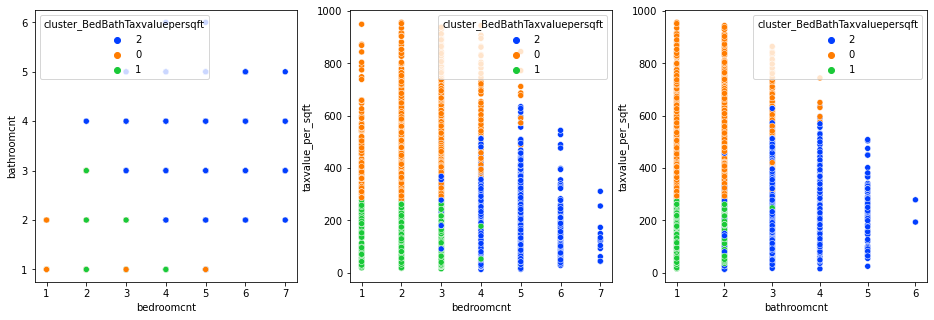

In [18]:
explore.viz_cluster_BedBathTaxvaluepersqft(train)

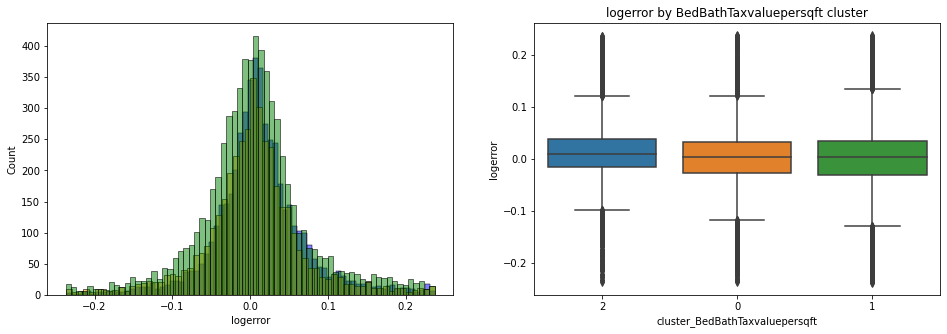

In [19]:
explore.viz_logerror_BedBathTaxvaluepersqft(train)

In [20]:
explore.test_cluster_BedBathTaxvaluepersqft(train)


H0:  There is no significant difference in logerror among the BedBathTaxvaluepersqft clusters.
H1:  There is a significant difference in logerror among the BedBathTaxvaluepersqft clusters.

alpha =  0.05

stat =  34.07793676095531
p =  1.7054045908566085e-15

Reject H0


Since p is less than alpha, we reject the null hypothesis, and we proceed under the assumption that there is a significant difference in logerror among the BedBathTaxvaluepersqft clusters. Therefore, we expect these clusters to be drivers of logerror.

#### Are there clusters based on location (latitude and longitude) that are drivers of logerror?

In our initial exploration, we created multiple sets of clusters using a K-means algorithm based on combinations of latitude and longitude, the results of which are visualized below using the `viz_multiple_clusters_LatLong` function:

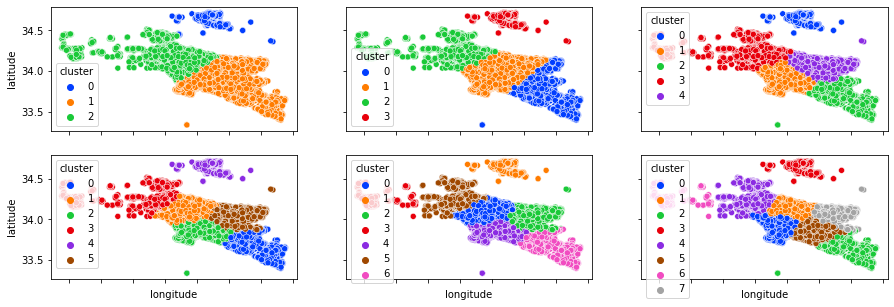

In [21]:
explore.viz_multiple_clusters_LatLong(train)

n-clusters=4 is the most visually intuitive set of clusters, since it identifies the geographically separated region to the north, then divides the remaining mass into regions that could be considered west, east, and central. Further, initial testing found that n_clusters=4 had the most significant variance in logerror among the clusters. 

For these reasons we decided to include this set of clusters in our modeling going forward. 

The `viz_logerror_LatLong` function displays the latitude/longitude points by cluster again, then visualizes difference in logerror among the clusters with histograms and boxplots:

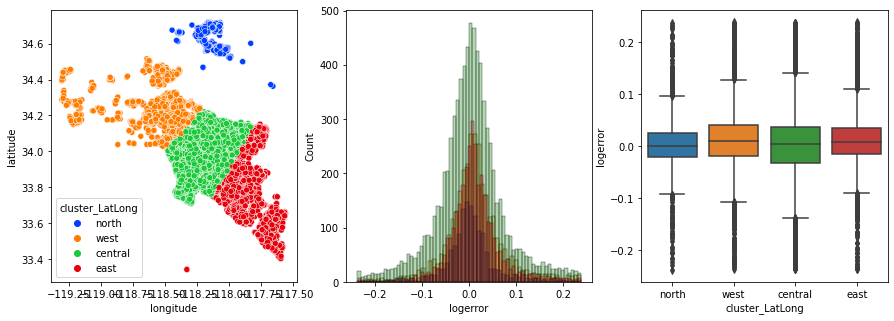

In [22]:
explore.viz_logerror_LatLong(train)

In [23]:
explore.test_cluster_LatLong(train)


H0:  There is no significant difference in logerror among the LatLong clusters.
H1:  There is a significant difference in logerror among the LatLong clusters.

alpha =  0.05

stat =  25.959645460084744
p =  9.599367109817317e-17

Reject H0


Since p is less than alpha, we reject the null hypothesis, and we proceed under the assumption that there is a significant difference in logerror among the LatLong clusters. Therefore, we expect these clusters to be drivers of logerror.

### Exploration - Summary

In this phase we identified the existing features that have the strongest correlations with the target variable, as well as created varioius clusters based on combinations of features that might be expected to be drivers of the target. Each of these groups of clusters was found to have at least some effect on logerror, so we will test these in combination with other features when creating our regression models. 

The clusters based on location (latitude and longitude) had the highest f-statistic when conducting ANOVA tests on variation in logerror, so we might expect these clusters to have the most significant impact. This is inline with domain-knowledge expectations, since real estate markets tend to be heavily influenced by location.

# Modeling

The code below sets up the necessary infrastructure for storing information about each of our models and their performance.

In [24]:
# creating the infrastructure necessary for storing information about models and their performance
model_info = pd.DataFrame()
model_results = pd.DataFrame()
model_number = 0

#### Establishing baseline performance

Next we will establish our baseline predictions and evaluate their performance.

To be able to determine whether our model gives useful predictions, we will compare it to a model that uses no features at all, and simply uses the mean or median value as a prediction for all observations.

The `run_baseline` function from the `model` module determines which metric performs better as a baseline, then stores information about baseline predictions and their performance for later evaluation.

In [25]:
model_number, model_info, model_results = model.run_baseline(train, validate, target, model_number, model_info, model_results)

### Modeling - without using cluster features

To determine whether our newly created cluster features are useful for modeling, we will first run each model without including the clusters as features

#### Without Clusters - Ordinary Least Squares (OLS) Regression

the `run_OLS` function creates an OLS regression model using the features previously identified as having the highest correlations with the target, then stores information about the model's performance for later evaluation.

In [26]:
model_number, model_info, model_results = model.run_OLS(train, validate, target, model_number, model_info, model_results)

#### Without Clusters - Polynomial Regression

The `run_PolyReg` function creates various polynomial regression models using the features previously identified as having the highest correlations with the target, varying the argument used for degree of the polynomial. It then stores information about the models' performance for later evaluation.

In [27]:
model_number, model_info, model_results = model.run_PolyReg(train, validate, target, model_number, model_info, model_results)

### Modeling - using cluster features

Now we add the previously created cluster features to our models, so that we can compare model performance with and without these features.

#### With Clusters - Ordinary Least Squares (OLS) Regression

the `run_OLS_with_clusters` function creates various OLS regression models and stores information about their performance for later evalation. Each model uses our previously identified feature set combined with one of the cluster features.

In [28]:
model_number, model_info, model_results = model.run_OLS_with_clusters(train, validate, target, model_number, model_info, model_results)

#### With Clusters - Polynomial Regression

The `run_PolyReg_with_clusters` function creates various Polynomial Regression models and stores information about their performance for later evaluation. Each model uses the set of features most highly correlated with the target and includes one of the cluster features. The degree of the polynomial is also varied between 2-4 for each of the combinations of features. 

In [29]:
model_number, model_info, model_results = model.run_PolyReg_with_clusters(train, validate, target, model_number, model_info, model_results)

## Modeling - Evaluation

Root Mean Squared Error (RMSE): This is the metric we will use to evaluate the performance of our models. The RMSE tells us the standard deviation of the difference between our predictions and the actual values and therefore gives us an idea of how spread out the actual data points are around our regression line. Of the possible metrics for evaluating regression models, RMSE is easiest to interpret since it is expressed in units that are equivalent to our target variable (logerror in this case).

The following features were included in all of the models:
- sqft
- bedroomcnt
- bathroomcnt
- fullbathcnt
- age
- assessmentyear
- yearbuilt

In addition, the below table shows the type of model, polynomial degree, and cluster features that were included in each model.

In [30]:
# display model_info df
model_info.drop(columns='features')

,model_number,model_type,degree,cluster
0,baseline,baseline,NaN,NaN
1,1,OLS regression,NaN,NaN
2,2,polynomial regression,2.0,NaN
3,3,polynomial regression,3.0,NaN
4,4,polynomial regression,4.0,NaN
5,5,OLS regression,NaN,BedBath
6,6,OLS regression,NaN,BedBathSqft
7,7,OLS regression,NaN,LatLong
8,8,OLS regression,NaN,BedBathTaxvaluepersqft
9,9,polynomial regression,2.0,BedBath


And here we can see the Root Mean Squared Error (RMSE) of the logerror predictions for each model on both the train and validate samples

In [31]:
model.display_model_results(model_results)

model_number                    1         2         3         4         5  \
metric_type sample_type                                                     
RMSE        train        0.066659  0.066641  0.067870  0.065908  0.066652   
            validate     0.065633  0.065907  0.067261  0.066492  0.065621   

model_number                    6         7         8         9        10  \
metric_type sample_type                                                     
RMSE        train        0.066652  0.066558  0.066644  0.066436  0.066471   
            validate     0.065618  0.065635  0.065609  0.065743  0.065699   

model_number                   11        12        13        14        15  \
metric_type sample_type                                                     
RMSE        train        0.066336  0.066452  0.067762  0.067804  0.066008   
            validate     0.065724  0.065764  0.067668  0.070668  0.065972   

model_number                   16             17            18            19  \
metric_type sample_type                                                        
RMSE        train        0.066084       0.068925      0.068246  6.565349e-02   
            validate     0.065933  220612.784853  20108.841443  2.969732e+06   

model_number                   20  baseline  
metric_type sample_type                      
RMSE        train        0.065574  0.066873  
            validate     0.068228  0.065904

Here are our top 3 performing models:

In [32]:
model.display_model_results(model.get_best_model_results(model_results))

model_number                    5         6         8
metric_type sample_type                              
RMSE        train        0.066652  0.066652  0.066644
            validate     0.065621  0.065618  0.065609

### Model Evaluation - Final Test

Now we will take the best model and evaluate its performance on our test sample. This will approximate the expected performance of this model for predicting logerror of additional properties in real-time.

**Model #8**, an OLS regression, is our highest performing model. 

It has an RMSE logerror of .06664 on the train sample, and .06561 on the validate sample. 

It uses the following features:
- sqft
- bedroomcnt
- bathroomcnt
- fullbathcnt
- age
- assessmentyear
- yearbuilt
- a cluster feature based on a combination of:
    - bedroomcnt
    - bathroomcnt
    - taxvaluepersqft
    
The `test_model_8` function recreates this model and tests its results.

In [33]:
# calculate the RMSE for model 8 on the test sample
model.test_model_8(train, test, target)

Model #8 RMSE on test sample: 0.0662587


# Conclusion

### How did we do?

We expect that our top performing model will typically predict a logerror value that is within .066259 of the actual logerror value. While this is a small error, it is only slightly better than our baseline of .066873. While this indicates that we may not be able to improve the Zestimate by leaps and bounds, we have successfully identified drivers of error in the estimate, and have created a jumping-off point for further analysis and modeling.

### Key Findings:

We found the following combinations of features created clusters that proved to be drivers of logerror (however minor):
- bedroomcnt, bathroomcnt
- bedroomcnt, bathroomcnt, sqft
- bedroomcnt, bathroomcnt, taxvalue_persqft
- latitude, longitude

### Recommendations:

While we did find features that are drivers of logerror, the effect size was minor, so I would not recommend using the models created here as the sole basis for improving the Zestimate. However, clustering was shown to be a useful exercise, so additional clustering exploration is recommended in an attempt to find clusters that serve as larger drivers. 

###  Next Steps:

Given more time, we should examine additional combinations of features that might create useful clusters. Additionally, we should test additional numbers of K-means clusters for each combination of features that were used in this report. 

Further, since real estate markets are based heavily on location, I might expect models to perform better which individually focus on a distinct geographic area. So, we could create a different model for each of our latitude/longitude clusters, or we could further narrow the geographic focus by using zip code or neighborhood information or by creating a larger number of latitude/longitude clusters. 